### Install and Import Packages

In [ ]:
! pip install pandas
! pip install Image
! pip install matplotlib
! pip install numpy
! pip install scikit-image
! pip install scikit-learn
! pip install opencv-python
! pip install seaborn
! pip install torch torchvision efficientnet_pytorch


In [43]:
import os, copy
import cv2
import pickle
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
import matplotlib.pylab as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from efficientnet_pytorch import EfficientNet

### Global Variables - Paths

In [44]:
CSV_PATH = 'classifications.csv'
IMAGE_SET_PATH = 'dataset'
CLASSES_PATH = 'classes'
MODELS_PATH = 'models'

### Functions

In [45]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Loading and Filtering Data

In [46]:
def filter_existing_images(data):
    existing_imgs = []
    missing_img = []

    for index, row in data.iterrows():
        
        image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
        if os.path.isfile(image_path):
            existing_imgs.append(index)
        else:
            missing_img.append(row['image_filename'])

    filtered_data = data.loc[existing_imgs]
    filtered_data['bethesda_system'] = filtered_data['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
    return filtered_data

#### Cropping and Saving Images

In [47]:
def make_class_dir (classes):
    for class_name in classes:
        os.makedirs(os.path.join(CLASSES_PATH, class_name), exist_ok=True)

In [48]:
def get_crop_box (x, y, width, height, crop_size = 100):
    half_crop = crop_size // 2
    left = max(0, x - half_crop)
    upper = max(0, y - half_crop)
    right = min(width, x + half_crop)
    lower = min(height, y + half_crop)

    if right - left < crop_size:
        if left == 0:
            right = left + crop_size
        else:
            left = right - crop_size
    if lower - upper < crop_size:
        if upper == 0:
            lower = upper + crop_size
        else:
            upper = lower - crop_size

    return (left, upper, right, lower)

#### Feature Extraction

In [49]:
def generate_grayscale_histogram(img, bins = 16):
    grayscale_image = img.convert("L")
    histogram, bin_edges = np.histogram(grayscale_image, bins=bins, range=(0,255))

    return histogram

In [50]:
def generate_hsv_histogram(img, h_bins=16, v_bins=8):
    hsv_img = img.convert("HSV")
    h, s, v = hsv_img.split()
    h = np.array(h) // (256 // h_bins)
    v = np.array(v) // (256 // v_bins)
    histogram, _, _ = np.histogram2d(h.flatten(), v.flatten(), bins=[h_bins, v_bins], range=[[0, h_bins], [0, v_bins]])
    return histogram

In [51]:
def quantize_image(image, levels = 16):
    grayscale_image = image.convert("L")
    quantized_image = np.array(grayscale_image) // (256 // levels)
    return quantized_image

In [52]:
def compute_cooccurrence_matrices(q_img, distances=[1, 2, 4, 8, 16, 32], angles=[0]):
    cooccurrence_matrices = graycomatrix(q_img, distances, angles, levels=16, symmetric=True, normed=True)
    return cooccurrence_matrices


In [53]:
def compute_glcm(q_img, dists=[1, 2 ,4, 8, 16, 32], angles=[0]):
    glcm = graycomatrix(q_img, distances=dists, angles=angles, levels=16, symmetric=True, normed=True)
    return glcm

In [54]:
def compute_haralick_features(glcm):
    contrast = graycoprops(glcm, 'contrast').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    
    glcm_sum = glcm.sum(axis=(0, 1))
    norm_glcm = glcm / glcm_sum
    entropy = -np.sum(norm_glcm * np.log(norm_glcm + 1e-10), axis=(0, 1)).flatten()
    
    features = {
        'contrast': contrast,
        'homogeneity': homogeneity,
        'entropy': entropy
    }
    return features

In [55]:
def load_data(classes, image_size=(100, 100)):
    images = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(CLASSES_PATH, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = Image.open(img_path).resize(image_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_name)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [56]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#### EfficientNet Functions 

In [66]:
def copy_train_test_imgs (train_df, test_df, class_column_name, data_dir):

    train_dir_path = 'train'
    test_dir_path = 'test'

    train_dir_path = os.path.join(data_dir, train_dir_path)
    test_dir_path = os.path.join(data_dir, test_dir_path)

    for index, row in train_df.iterrows():
            cell_id = row['cell_id']
            train_class_dir = os.path.join(train_dir_path, row[class_column_name])
            if not os.path.exists(train_class_dir):
                os.makedirs(train_class_dir)
            src_path = row['image_path']
            dst_path = os.path.join(train_class_dir, f'{cell_id}.png')
            shutil.copy(src_path, dst_path)

    for index, row in test_df.iterrows():
            cell_id = row['cell_id']
            test_class_dir = os.path.join(test_dir_path, row[class_column_name])
            if not os.path.exists(test_class_dir):
                os.makedirs(test_class_dir)
            src_path = row['image_path']
            dst_path = os.path.join(test_class_dir, f'{cell_id}.png')
            shutil.copy(src_path, dst_path)

In [72]:
def get_data_tranforms():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),  # Redimensiona para 256x256 antes do recorte aleatório
            transforms.RandomResizedCrop(224),  # Recorta aleatoriamente para 224x224
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),  # Redimensiona para 256x256 antes do recorte central
            transforms.CenterCrop(224),  # Recorta centralmente para 224x224
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

In [73]:
def train_model(model, dataloaders, criterion, optimizer, device, dataset_sizes, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Cada época possui uma fase de treino e uma de validação
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Configura o modelo para treinamento
            else:
                model.eval()   # Configura o modelo para avaliação

            running_loss = 0.0
            running_corrects = 0

            # Itera sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zera os gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward
                # Track history se apenas na fase de treino
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + otimiza apenas na fase de treino
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Profunda cópia do modelo
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Carrega os melhores pesos do modelo
    model.load_state_dict(best_model_wts)
    return model

In [81]:
def evaluate_model(model, dataloaders, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

### Main

#### Loading and Filtering Data

In [58]:
brute_data = pd.read_csv(CSV_PATH)
table_data = filter_existing_images(brute_data)

##### Dataset

#### Cropping and Saving Images

In [ ]:
make_class_dir(table_data['bethesda_system'].unique())

for index, row in table_data.iterrows():
    image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
    x, y = int(row['nucleus_x']), int(row['nucleus_y'])
    class_name = row['bethesda_system']
    cell_id = row['cell_id']

    with Image.open(image_path) as img:
        width, height = img.size
        crop_box = get_crop_box(x, y, width, height)
        cropped_img = img.crop(crop_box)

        output_path = os.path.join(CLASSES_PATH, class_name, f'{cell_id}.png')
        cropped_img.save(output_path)

#### Feature Extraction

In [60]:
img_data = []

for index, row in table_data.iterrows():
    cell_id = row['cell_id']
    img_path = os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png")
    img_class = row['bethesda_system']

    image = Image.open(img_path)

    if image is not None:
        q_img = quantize_image(image)
        glcm = compute_glcm(q_img)
        haralick_features = compute_haralick_features(glcm)

        img_data.append ({
            'cell_id': cell_id,
            'image_path': img_path,
            'contrast_1': haralick_features['contrast'][0],
            'contrast_2': haralick_features['contrast'][1],
            'contrast_4': haralick_features['contrast'][2],
            'contrast_8': haralick_features['contrast'][3],
            'contrast_16': haralick_features['contrast'][4],
            'contrast_32': haralick_features['contrast'][5],
            'homogeneity_1': haralick_features['homogeneity'][0],
            'homogeneity_2': haralick_features['homogeneity'][1],
            'homogeneity_4': haralick_features['homogeneity'][2],
            'homogeneity_8': haralick_features['homogeneity'][3],
            'homogeneity_16': haralick_features['homogeneity'][4],
            'homogeneity_32': haralick_features['homogeneity'][5],
            'entropy_1': haralick_features['entropy'][0],
            'entropy_2': haralick_features['entropy'][1],
            'entropy_4': haralick_features['entropy'][2],
            'entropy_8': haralick_features['entropy'][3],
            'entropy_16': haralick_features['entropy'][4],
            'entropy_32': haralick_features['entropy'][5],
            'img_class': img_class
        })
        
dataset = pd.DataFrame(img_data)


In [ ]:
dataset

In [ ]:
features = dataset.drop(columns=['cell_id', 'image_path', 'img_class'])
labels = dataset['img_class']

#### Binary SVM Classifier

##### Split and Balance Data

In [ ]:
binary_labels = np.array(['Negative' if label == 'Negative_for_intraepithelial_lesion' else 'Positive' for label in labels])

X_train, X_test, y_train, y_test = train_test_split(features, binary_labels, test_size=0.2, stratify=binary_labels, random_state=49)

# Step 1: Undersample the predominant class
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=49, k_neighbors=5, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_res, y_res)


##### GridSearch for Best Hyperparameters

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 'scale'],
    'kernel': ['linear', 'rbf']
}

# Create a base model
svc = SVC(class_weight='balanced', random_state=49)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_

In [ ]:
print(f"Best parameters found: {best_params}")

##### Train and Evaluate the Binary Model

In [ ]:
binary_svm_classifier = SVC(**best_params, class_weight='balanced', random_state=49)
binary_svm_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = binary_svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))

print("Binary SVC Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
plot_confusion_matrix(conf_matrix, classes=['Negative', 'Positive'])

##### Saving the Binary SVM Classifier Model

In [ ]:
model_filename = 'binary_svm_classifier1.pkl'

model_path = os.path.join(MODELS_PATH, model_filename)

with open(model_path, 'wb') as file:
    pickle.dump(binary_svm_classifier, file)

# Load the model
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print("Loaded Model Accuracy:", accuracy_loaded)

#### Multiclass SVM Classifier

##### Split and Balance Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=49)

# Step 1: Undersample the predominant class
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=49, k_neighbors=5, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_res, y_res)


##### RandomizedSearch for Best Hyperparameters

In [ ]:
param_distributions = {
    'C': loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-6, 1e-1),
    'kernel': ['linear', 'rbf', 'sigmoid']
}

# Create a base model
svc = SVC(class_weight='balanced', random_state=49)

# Instantiate the randomized search model
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=49)

# Time the randomized search
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_

In [ ]:
print(f"Best parameters found: {best_params}")

##### Train and Evaluate the Multiclass Model

In [ ]:
multiclass_svm_classifier = SVC(**best_params, class_weight='balanced', random_state=49)
multiclass_svm_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = multiclass_svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))

print("Multi-Class SVM Accuracy:", accuracy)
print("Multi-Class SVM Confusion Matrix:\n", conf_matrix)

In [ ]:
plot_confusion_matrix(conf_matrix, classes=['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative_for_intraepithelial_lesion', 'SCC'])

##### Saving the Multiclass SVM Model

In [ ]:
model_filename = 'multiclass_svm_classifier.pkl'

model_path = os.path.join(MODELS_PATH, model_path)

with open(model_filename, 'wb') as file:
    pickle.dump(multiclass_svm_classifier, file)

# Load the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print("Loaded Model Accuracy:", accuracy_loaded)

#### Binary EfficientNet Classifier

##### Split and Treat Data

In [71]:
df = dataset.copy()
class_name = 'binary_class'
bin_data_dir = 'effnet_data_binary'

df[class_name] = df['img_class'].apply(lambda x: 'Negative' if x == 'Negative_for_intraepithelial_lesion' else 'Positive')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[class_name], random_state=49)

copy_train_test_imgs(train_df,test_df, class_name, bin_data_dir)

##### Preparing For Training

In [74]:
batch_size = 32
data_transforms = get_data_tranforms()

image_datasets = {x: datasets.ImageFolder(os.path.join(bin_data_dir, x),data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [75]:
train_labels = np.array([label for _, label in image_datasets['train'].imgs])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Criação de um WeightedRandomSampler
class_sample_counts = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weights = 1. / class_sample_counts
samples_weights = weights[train_labels]

sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Atualizando o DataLoader de treino para usar o WeightedRandomSampler
train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4)
test_loader = dataloaders['test']
dataloaders['train'] = train_loader

In [76]:
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [77]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Train Model

In [78]:
model_binary_efficientNet = train_model(model, dataloaders, criterion, optimizer, device, dataset_sizes, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.4995 Acc: 0.5907
test Loss: 0.8977 Acc: 0.4100

Best val Acc: 0.410027


##### Evaluate Model

Acurácia: 0.4100
Precisão: 0.7921
Recall: 0.4100
F1-score: 0.3925


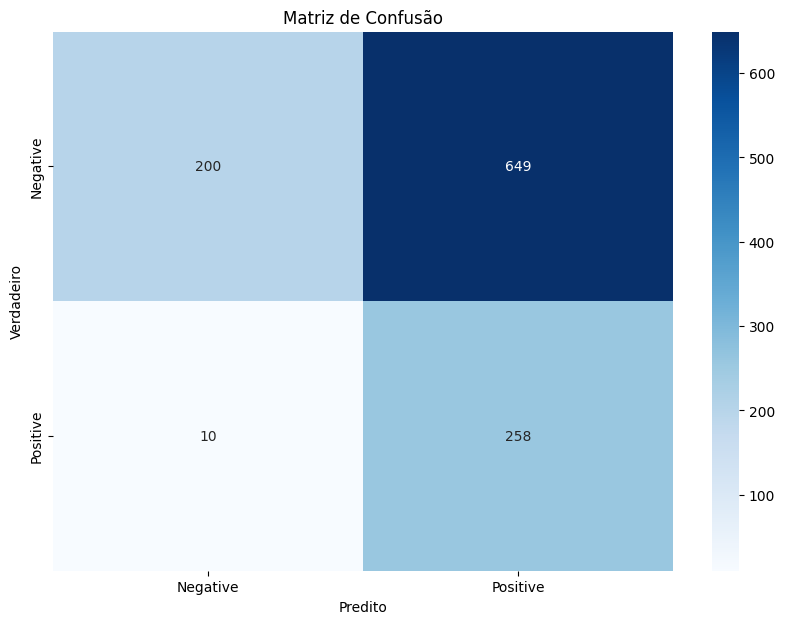

              precision    recall  f1-score   support

    Negative       0.95      0.24      0.38       849
    Positive       0.28      0.96      0.44       268

    accuracy                           0.41      1117
   macro avg       0.62      0.60      0.41      1117
weighted avg       0.79      0.41      0.39      1117



In [82]:
model_binary_efficientNet = model_binary_efficientNet.to(torch.device('cuda:0'))

# Avalia o modelo no conjunto de teste
labels, preds = evaluate_model(model_binary_efficientNet, dataloaders, device)

# Calcula acurácia, precisão, recall e F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Imprime as métricas
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(labels, preds)

# Converte a matriz de confusão para um DataFrame para melhor visualização
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plota a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação detalhado
report = classification_report(labels, preds, target_names=class_names)
print(report)

##### Save Model

In [ ]:
# Salva o modelo
path = 'models/efficientNet_binary1.pth'
torch.save(model_binary_efficientNet.to(torch.device('cpu')), path)

#### Multiclass EfficientNet Classifier

##### Split and Treat Data

In [70]:
df = dataset.copy()
class_name = 'img_class'
multi_data_dir = 'effnet_data_multiclass'

df = df[df[class_name] != 'Negative_for_intraepithelial_lesion']

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[class_name], random_state=49)

copy_train_test_imgs(train_df,test_df, class_name, multi_data_dir)

##### Preparing For Training

In [ ]:
batch_size = 32
data_transforms = get_data_tranforms()

image_datasets = {x: datasets.ImageFolder(os.path.join(multi_data_dir, x),data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)

In [ ]:
train_labels = np.array([label for _, label in image_datasets['train'].imgs])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Criação de um WeightedRandomSampler
class_sample_counts = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weights = 1. / class_sample_counts
samples_weights = weights[train_labels]

sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Atualizando o DataLoader de treino para usar o WeightedRandomSampler
train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4)
test_loader = dataloaders['test']
dataloaders['train'] = train_loader

In [ ]:
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### Train Model

In [ ]:
model_multiclass_efficientNet = train_model(model, dataloaders, criterion, optimizer, device,  dataset_sizes, num_epochs=1)

##### Evaluate Model

In [ ]:
# Avalia o modelo no conjunto de teste
model_multiclass_efficientNet = model_multiclass_efficientNet.to(torch.device('cuda:0'))
labels, preds = evaluate_model(model_multiclass_efficientNet, dataloaders, device)

# Calcula acurácia, precisão, recall e F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Imprime as métricas
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(labels, preds)

# Converte a matriz de confusão para um DataFrame para melhor visualização
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plota a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação detalhado
report = classification_report(labels, preds, target_names=class_names)
print(report)

##### Save Model

In [ ]:
# Salva o modelo
path = 'models/efficientNet_muticlass.pth'
torch.save(model_multiclass_efficientNet.to(torch.device('cpu')), path)